# Code for the paper "Spatial search with multiple marked vertices is optimal for almost all queries and its quantum advantage is not always guaranteed"

In [1]:
# Maths and data management
import math
from math import pi
import numpy as np
import pandas as pd
import pickle
import time
import datetime
from multiprocessing import Pool

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Fitting curves
from scipy.optimize import curve_fit

# Simulation package
import qwsearch

# Plotting configuration
%matplotlib inline
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

## 1. Quantum walk implementation
This section's aim is to implement the quantum walk of the paper and simulate it using numpy.

The walk is on a grid of size $2^{nb}\times 2^{nb}$ where $nb$ is the size parameter. Most of the time, we define $N=2^{nb}$
### Toolkit
   - `kron_power` : $U,n \mapsto U^{\otimes n}$
   - `dot_multiple` : $M_1,\ldots,M_n \mapsto M_1 \times \ldots \times M_n$
   - `get_proba` : $|\psi> \mapsto \left(\mathbb{P}\left[(x,y)=(i,j) \mid (x,y) \overset{Measure}{\longleftarrow} |\psi> \right]\right)_{i,j}$

In [2]:
def kron_power(U,n):
    """
    Entries :
        U -> A numpy matrix.
        n -> An integer.
    Output :
        U to the kronecker power n.
    """
    tmp = np.array([[1.]])
    for i in range(n):
        tmp = np.kron(tmp,U)
    return tmp

In [3]:
def dot_multiple(l):
    """
    Entry :
        l -> A list of numpy matricies.
    Output :
        The dot product of all the matricies in l.
    """
    assert(len(l)!=0)
    tmp = np.eye(len(l[0]))
    for i in range(len(l)):
        tmp = np.dot(tmp,l[i])
    return tmp

In [4]:
def get_proba(psi):
    """
    Entry :
        psi -> The state of the quantum walk.
    Output :
        The probability to be in each position of the grid in the form of a matrix of size NxN$
    """
    N = int(np.sqrt(len(psi)/2))
    l = np.array([np.abs(psi[i])**2+np.abs(psi[N*N+i])**2 for i in range(N*N)])
    return np.reshape(l,(N,N))

### Actual implementation
The walk operator is defined as below.
$$ U = (I_2\otimes SW) \times (\sigma\otimes I_{N}) \times (I_2\otimes SW) \times (C_y\otimes I_{N^2}) \times (\sigma\otimes I_{N}) \times (C_x\otimes I_{N^2}) $$
We define the following operators :
   - $U_{trans} = \sigma\otimes I_{N}$
   - $U_{swap} = I_2\otimes SW$
   - $U_{Xcoin} = C_x\otimes I_{N^2}$
   - $U_{Ycoin} = C_y\otimes I_{N^2}$
   
The operator of the walk is thus 
$$ U = U_{swap} \times U_{trans} \times  U_{swap} \times U_{Ycoin} \times U_{trans} \times U_{Xcoin} $$
And we don't forget the oracle $R$.
$$ R_{i,j} = (-1)^{\mathbb{1}_{(i,j)\in \mathcal{M}}} \mathbb{1}_{i=j} $$
$$ U_R = I_2\otimes R $$

The purpose of the function `get_matrix_qw` is to create all those matricies and return $U$ as well as $U'=UR$. 

In [5]:
def get_matrix_qw(nb,search=[]):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
    Outputs : {1},{2}
        {1} -> The operator U of the walk.
        {2} -> The operator U' of the search (walk and oracle).
    """
    
    def mod_number(x,N):
        l = list(map(int,list(bin(x)[2:])))
        l = [0]*(N-len(l))+l
        l = [l[len(l)-i-1] for i in range(len(l))]
        y = 0
        for i in range(N):
            y += l[(i+N//2)%N]*2**i
        return y
    

    N = 2**nb

    X = np.array([[1 if (i-j+N)%N == 1 else 0 for j in range(N)] for i in range(N)],dtype=float)
    sig = np.array([[X[i,j] if i<N and j<N else (X[j-N][i-N]if i>=N and j>=N else 0) for j in range(2*N)] for i in range(2*N)],dtype=float)
    U_trans = np.kron(sig,np.eye(N)) # sig \otimes I_N
    
    SW = np.array([[1 if mod_number(i,2*nb)==j else 0 for j in range(N*N)] for i in range(N*N)],dtype=float)
    U_swap = np.kron(np.eye(2),SW) # I_2 \otimes SW
    
    Cx = np.array([[1,1j],[1j,1]])/np.sqrt(2) # Coin X
    U_Xcoin = np.kron(Cx,np.eye(N*N))
    
    Cy = np.array([[1,-1j],[-1j,1]])/np.sqrt(2) # Coin Y
    U_Ycoin = np.kron(Cy,np.eye(N*N))
    
    U = dot_multiple([U_swap,U_trans,U_swap,U_Ycoin,U_trans,U_Xcoin])
    
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R) # Oracle
    
    return U,np.dot(U,U_R)

### Simulation function

Now that we have a function that gives the operator of the walk, we want to simulate it by multiplying the operator several times.

However, creating the matrix can take some times, especially if we want to make a lot of simulations. That's why we propose to compute the operator $U$ in advance for different size of quantum walk. This allow you to save up some time when trying to compute statistics later. Of course, those matrices can be loaded via pickle instead of being computed again.

In [6]:
U_save = []
for i in range(1,6):
    tmp,_ = get_matrix_qw(i,[])
    U_save.append(tmp)

Here is the actual simulation function. The number of steps is either specified or automatically adjusted.

In [7]:
def simul_matrix_opt(nb,search,m=-1):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output :
        A grid of size NxN giving the probability distribution of the walker.
    """
    global U_save
    N = 2**nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    
    psi = np.dot(np.linalg.matrix_power(U,m),psi) # Final state
    return np.array(get_proba(psi),dtype=float)

[(4, 0)]
0.19140624999999942


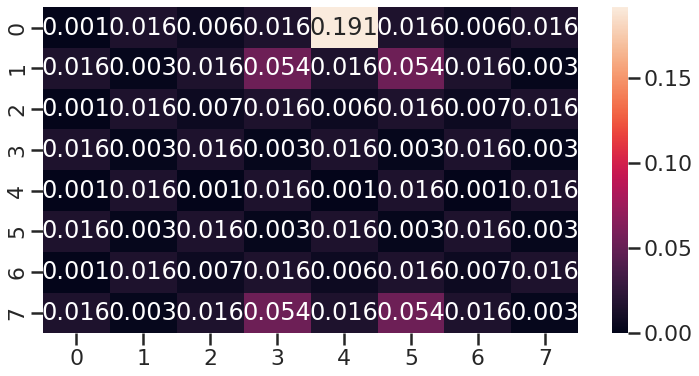

In [8]:
plot_mat = lambda mat:sns.heatmap(mat, annot=True, fmt="0.3f", vmin=0) # Function to plot a matrix as an image.

plt.figure(figsize=(12,6))

oracle = [4] # Marked elements
print([(i%8,i//8) for i in oracle]) 

res = simul_matrix_opt(3,oracle) # Make the simulation ...
plot_mat(res) # ... and plot it.
print(sum([res[i//8,i%8] for i in oracle]))

This second function do the same job, but instead of giving the probabilities at the last step, it  shows the probabilities of success at each step.

In [9]:
def simul_proba_opt(nb,search,m=-1):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output : {1},{2}
        [1} -> The list of the steps for which we make a measurement.
        {2} -> The probability of success for each step between 0 and m included.
    """
    global U_save
    N = 2**nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)
    
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    p=[]
    M=[]
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    M.append(0)
    res = get_proba(psi)
    p.append(sum([res[i//N,i%N] for i in search]))
    
    for i in range(1,m+1):
        M.append(i)
        psi = np.dot(U,psi)
        res = get_proba(psi)
        p.append(sum([res[i//N,i%N] for i in search]))
    return M,p

def simul_proba_rust(nb,search,m=-1):
    N = 2**nb
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    p = qwsearch.qw_signal(N,m,search)
    M = list(range(p))
    return 

[(4, 0)]


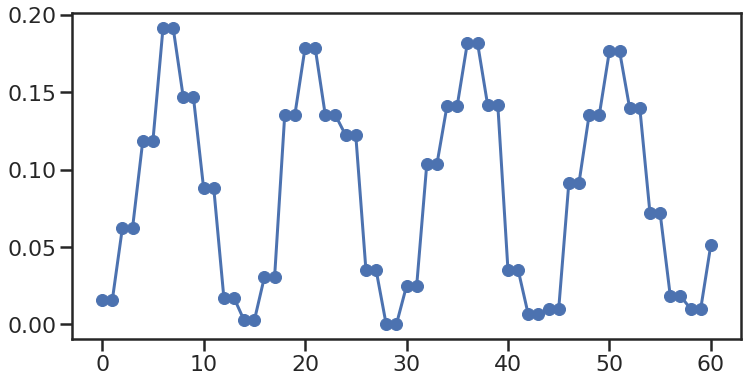

In [10]:
oracle = [4] # Marked elements
print([(i%8,i//8) for i in oracle]) 

m,p = simul_proba_opt(3,oracle,60)

plt.figure(figsize=(12,6))
plt.plot(m,p,'o-')

## 2. Different configurations of marked elements and eigenvalues
We look at the argument $\lambda$ of the eigenvalue of $U$ such that $\lambda$ is the argument closest to $0$ but $\lambda > 0$.

We also look at the fitted value $\tilde{\lambda}$ obtained by fitting $a\sin(\tilde{\lambda}t+b)$ for the signal.

In [11]:
def get_eigen(U):
    """
    Entry :
        U -> An operator.
    Output :
        The eigenvalue's argument lambda as defined in the paper.
    """
    norm = lambda x:np.sqrt(sum([abs(i)**2 for i in x]))
    val,vec = np.linalg.eig(U)
    l = [[np.angle(val[i]),vec[:,i]/norm(vec[:,i])] for i in range(len(val))]
    lbd = min([i for i in l if i[0]>1e-10],key=lambda x:x[0])
    return lbd[0]

In [12]:
def plot_walk(nb,search,path):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        path -> The path of the file for the figure.
    Output :
        The function don't output anything but plot a figure of the signal of the walk. 
        This figure is printed here and saved according to the path specified.
        The searched elements, lambda and fitted value of lambda are displayed.
    """
    global U_save
    N=2**nb
    
    x,y = simul_proba_opt(nb,search,50) # Get the signal
    
    # We compute the search operator for finding the value of lambda
    while nb > len(U_save):
        tmp,_ = get_matrix_qw(i,[])
        U_save.append(tmp)
    R = np.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = np.kron(np.eye(2),R)
    U = np.dot(U_save[nb-1],U_R) # Search operator
    
    lbd = get_eigen(U) # Get lambda

    plt.figure(figsize=(12,8))
    plt.plot(x[::],y[::],'o--',label="search")

    t = np.linspace(x[0],x[-1],1000)
    
    # Model using lambda
    model = lambda t,a,b:a*np.sin(lbd*t+b)**2
    param = curve_fit(model,x,y)[0]
    f = lambda t:model(t,*param)
    plt.plot(t,f(t),label="predicted frequency")
    
    # Model where even the period (value of lambda) is fitted
    model = lambda t,a,b,lbd:a*np.sin(lbd*t+b)**2
    param = curve_fit(model,x[::],y[::],p0=[*param,0.2])[0]
    print(param)
    f = lambda t:model(t,*param)
    plt.plot(t,f(t),label="fit")
    
    print("seached elements : {}\nlbd : {}\nfit : {}".format(search,lbd,param[-1]))

    #plt.xscale("log")
    #plt.yscale("log")

    plt.xlabel("steps")
    plt.ylabel("probability of success")
    plt.legend()
    plt.savefig("img/{}.svg".format(path))

We now can display some signals to check that there is a problem with the period $\lambda$ in some cases.

[0.17386509 0.09678819 0.21613759]
seached elements : [0]
lbd : 0.2157298010766719
fit : 0.2161375889739974


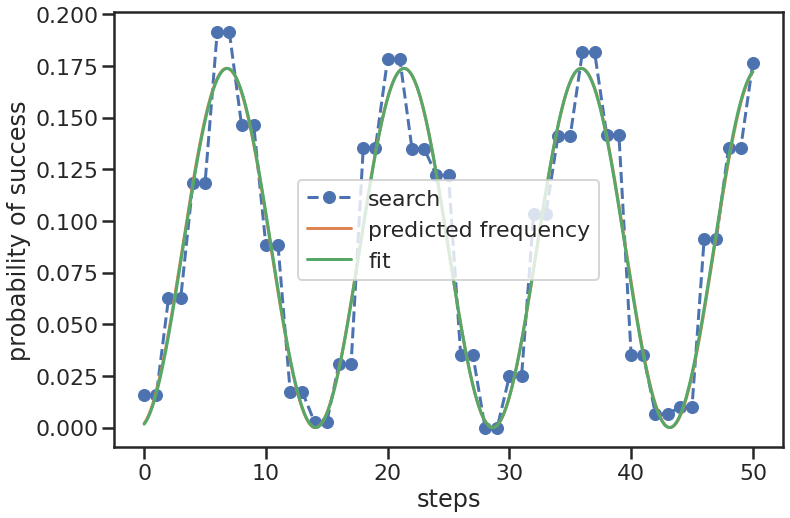

In [13]:
plot_walk(3,[0],"walk/aggreg1_proba")

[0.34773018 0.09678818 0.21613759]
seached elements : [0, 1]
lbd : 0.21572980107667136
fit : 0.21613758934710145


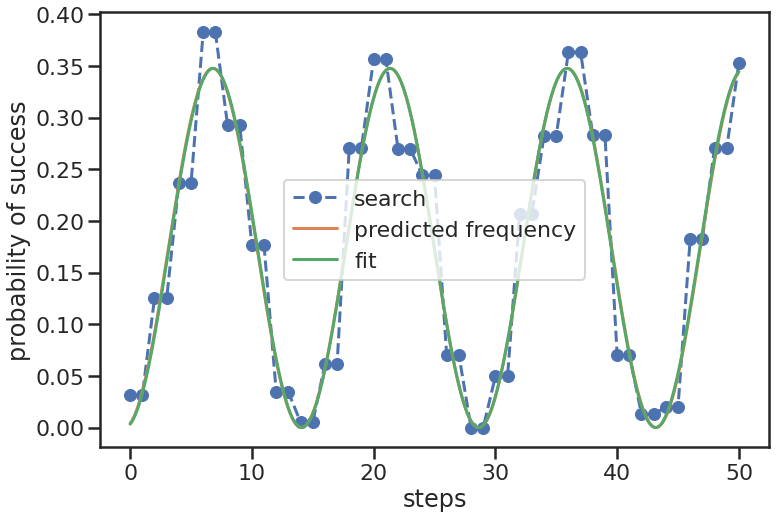

In [14]:
plot_walk(3,[0,1],"walk/aggreg2_proba")

[0.19526367 0.14125615 0.16738471]
seached elements : [0, 2]
lbd : 0.336498709036776
fit : 0.16738470903601105


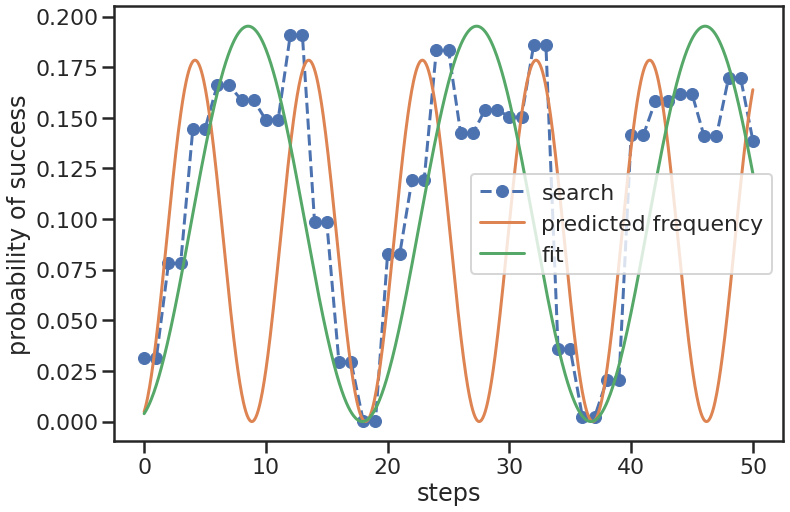

In [15]:
plot_walk(3,[0,2],"walk/interf1_proba")

[0.08185862 0.74215887 0.2216284 ]
seached elements : [0, 2, 4, 6]
lbd : 0.32433223627875535
fit : 0.22162840416841995


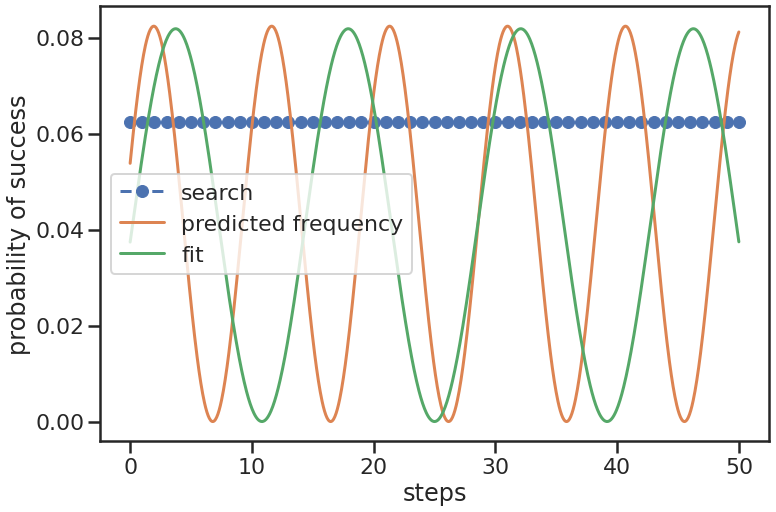

In [16]:
plot_walk(3,[0,2,4,6],"walk/interf2_proba")

[0.18681185 0.21956346 0.20366691]
seached elements : [0, 9]
lbd : 0.10306490444179352
fit : 0.20366690552510006


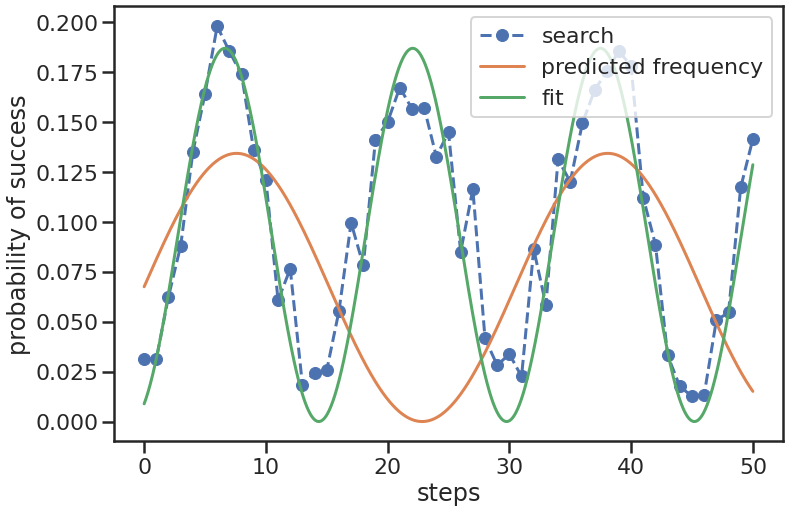

In [17]:
plot_walk(3,[0,9],"walk/mixed1_proba")

[0.17437367 0.24412243 0.16730836]
seached elements : [0, 18]
lbd : 0.05269802305609699
fit : 0.1673083571333958


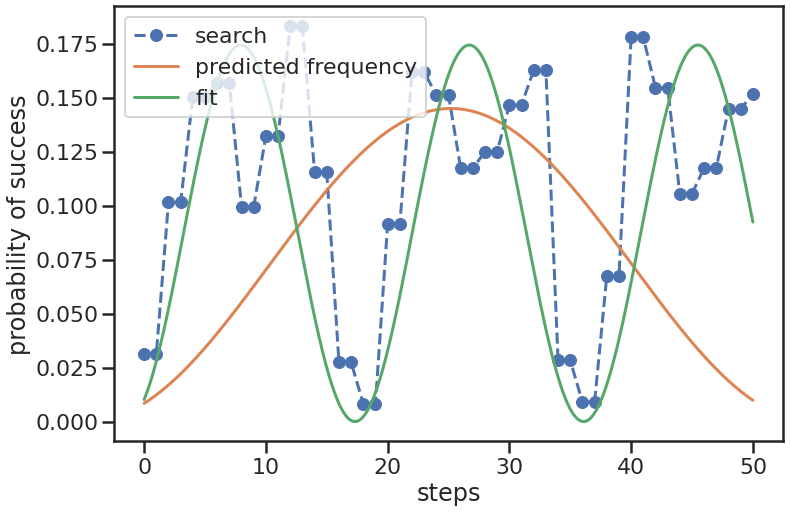

In [18]:
plot_walk(3,[0,18],"walk/mixed2_proba")

## 3. Statistics

The idea here is to check what  happens to the search performances in average over the marked elements configurations.

To do so, we save the results of several simulations with a configuration of marked element draw randomly uniformly.

The functions below add some simulations to the dataset. You can specify the size of the grid as well as the number of repetition for each number of marked elements. 

In [19]:
def simulation_rust(nb,num_iter=100,scale_hitting_time=False):
    """
    Entries :
        nb -> Size parameter for the grid.
        num_iter -> Number of repetitions.
        scale_hitting_time -> If True, the hitting time will be computed in function of N/M instead of N
    Output :
        For each number of marked elements between 1 and N^2-1, num_iter simulations will be performed and their content added to data.
        Each of the simulation draw a new configuration of marked elements.
    """
    N=2**nb
    
    data = {}
    data["n"]=[]
    data["M"] = []
    data["ratio"] = []
    data["p"] = []
    data["scale_hitting_time"] = []
    
    defects = list(range(1,int(0.06*N**2),int(1+N/1000)))+list(range(int(0.06*N**2),int(0.5*N**2),int(0.5*N**2/100)))
    
    starting_time = time.time()
    # Beginning the simulations ...
    for num_defect in defects:
        data["n"]+=[N]*num_iter
        data["M"]+=[num_defect]*num_iter
        data["ratio"]+=[num_defect/N**2]*num_iter
        data["scale_hitting_time"]+=[scale_hitting_time]*num_iter
        p = qwsearch.qw_sample(2**nb,num_defect,num_iter,scale_hitting_time)
        data["p"] += p
        completed = num_defect*100/len(defects)
        duration = time.time()-starting_time
        print("\r{}% (ETA : {})                  ".format(int(completed),datetime.timedelta(milliseconds=1000*int((100-completed)*duration/completed))),end="")
    print("\rdone                                                         ")
    return pd.DataFrame(data)


def simulation_rust2(nb,f=lambda x:int(x**0.5),num_iter=100,scale_hitting_time=False):
    """
    Entries :
        nb -> Size parameter for the grid.
        f -> Fonction that gives M(N) the number of marked elements.
        num_iter -> Number of repetitions.
        scale_hitting_time -> If True, the hitting time will be computed in function of N/M instead of N
    Output :
        For each grid size between 2x2 and 2^nb x 2^nb, num_iter simulations will be performed and their content added to data.
        Each of the simulation draw a new configuration of marked elements.
    """
    
    data = {}
    data["N"]=[]
    data["M"] = []
    data["ratio"] = []
    data["p"] = []
    data["scale_hitting_time"] = []
    
    grid_size = [2**i for i in range(1,nb)]
    
    starting_time = time.time()
    # Beginning the simulations ...
    for N in grid_size:
        num_defect = f(N**2)
        data["N"]+=[N**2]*num_iter
        data["M"]+=[num_defect]*num_iter
        data["ratio"]+=[num_defect/N**2]*num_iter
        data["scale_hitting_time"]+=[scale_hitting_time]*num_iter
        p = qwsearch.qw_sample(N,num_defect,num_iter,scale_hitting_time)
        data["p"] += p
        completed = (grid_size.index(N)+1)*100/len(grid_size)
        duration = time.time()-starting_time
        print("\r{}% (ETA : {})                  ".format(int(completed),datetime.timedelta(milliseconds=1000*int((100-completed)*duration/completed))),end="")
    print("\rdone                                                         ")
    return pd.DataFrame(data)

We run the simulations. 

**Warning: This code can take from a few minutes up to one hour depending of the computer you are using. It's parallelized and use a lot of ressources which will slow down your computer for a while.**

In [20]:
data = pd.concat([simulation_rust(4,100,True),simulation_rust(5,100,True),simulation_rust(6,100,True),simulation_rust(7,100,True)])
data2 = simulation_rust2(10,lambda x:int(x**0.5),10,True)
data3 = simulation_rust2(10,lambda x:int(np.log(x)),10,True)
data4 = simulation_rust2(10,lambda x:1,10,True)

done                                                         
done                                                         


done                                                         
done                                                         
done                                                         
done                                                         
done                                                         


We now plot the results of these simulations.

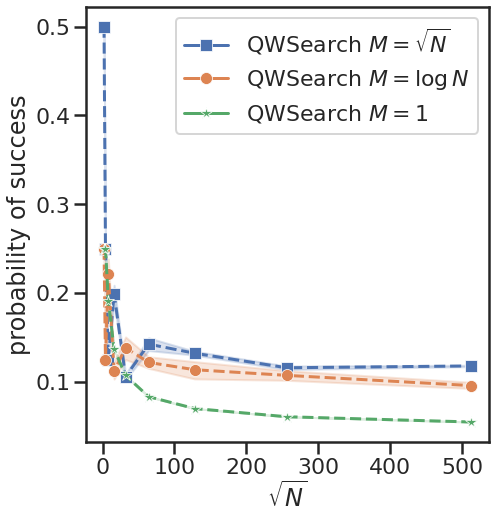

In [21]:
plt.figure(figsize=(8,8))

f = lambda tau:1.-(1.-tau)**(int(np.round((pi/4)*np.sqrt((1./tau)*np.log((1./tau))))))

ax1 = sns.lineplot(data=data2,x=np.sqrt(data2.N),y="p",dashes=False,label=r"QWSearch $M=\sqrt{N}$",marker="s")
ax2 = sns.lineplot(data=data3,x=np.sqrt(data3.N),y="p",dashes=False,label=r"QWSearch $M=\log{N}$",marker="o")
ax3 = sns.lineplot(data=data4,x=np.sqrt(data4.N),y="p",dashes=False,label=r"QWSearch $M=1$",marker="*")

for ax in [ax1,ax2,ax3]:
    for i in range(len(ax.lines)):
        ax.lines[i].set_linestyle('--')
        try:
            ax.lines[i].set_markeredgecolor(color[N[i]])
        except Exception:
            pass

x = np.linspace(min(data2.N),max(data2.N),100)
#ax4 = sns.lineplot(x=np.sqrt(x),y=[f(1./np.sqrt(i)) for i in x],label=r"classic $M=\sqrt{N}$")
#ax5 = sns.lineplot(x=np.sqrt(x),y=[f(np.log(i)/i) for i in x],label=r"classic $M=\log{N}$")
#ax6 = sns.lineplot(x=np.sqrt(x),y=[f(1/i) for i in x],label=r"classic $M=1$")

#plt.plot(x,0.3/np.sqrt(np.log(x)))
#plt.plot(np.log(x),0.18/np.log(np.sqrt(x)))
        
plt.xlabel(r"$\sqrt{N}$")
plt.ylabel("probability of success")

plt.gcf().subplots_adjust(left=0.2)

plt.savefig("img/proba_M_variable.pdf")

In [22]:
N = list(set(data['n']))

style = {}
style[N[0]]="v"; style[N[1]]="o"; style[N[2]]="s"; style[N[3]]="*"

color = {}
color[N[0]]="red"; color[N[1]]="blue"; color[N[2]]="green"; color[N[3]]="magenta"

l = [data[data.n==i] for i in N]
for i in range(len(l)):
    l[i] = l[i].groupby("M").mean()
agreg = pd.concat(l)

<Axes.ArtistList of 8 lines>


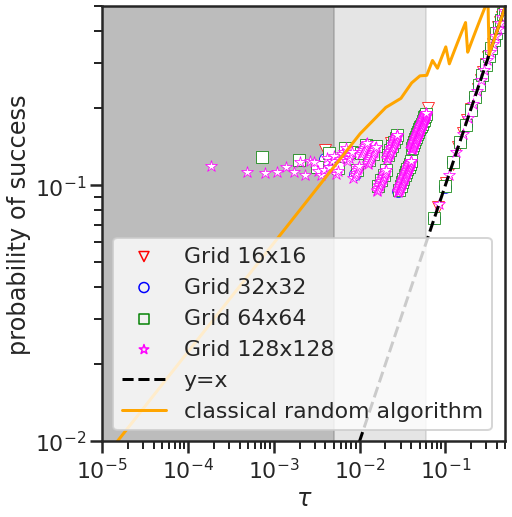

In [24]:
plt.figure(figsize=(8,8))
agreg = agreg.iloc[::-1]
ax = sns.lineplot(data=agreg[::5],x="ratio",y="p",hue="n",style="n",dashes=False,markers=style,markerfacecolor='white',markeredgecolor="black")
f = lambda x,N:1.-(1.-x)**(int(np.round((pi/4)*np.sqrt(N*np.log(N)))))


print(ax.lines)
for i in range(len(ax.lines)):
    ax.lines[i].set_linestyle('')
    try:
        ax.lines[i].set_markeredgecolor(color[N[i]])
    except Exception:
        pass

x = np.linspace(0,1,100)
i = 128
line1 = plt.plot(x,x,"--",color="black",label="y=x")


plt.fill([-1,0.06,0.06,-1],[-1,-1,2,2],color="grey",alpha=0.2)
plt.fill([-1,0.005,0.005,-1],[-1,-1,2,2],color="grey",alpha=0.4)


x = np.linspace(1e-5,1,100)
line2 = plt.plot(x,[f(i,1./i) for i in x],color="orange",label="classical random algorithm")

kws = {"s": 100, "facecolor": "none", "linewidth": 1.5}
handles, labels = zip(*[
    (plt.scatter([], [], ec=color,marker=style[key], **kws), "Grid {}x{}".format(key,key)) for key, color in color.items()
])
#plt.legend(handles+(plt.plot([],[],"--",color="black")[0],plt.plot([],[],"-",color="orange")[0]), labels+("y=x","GAM fit"), title="", loc=4)
plt.legend(handles+(plt.plot([],[],"--",color="black")[0],plt.plot([],[],"-",color="orange")[0]), labels+("y=x","classical random algorithm"), title="")
plt.xlabel(r"$\tau$")
plt.ylabel("probability of success")
plt.xlim([1e-5,0.5])
plt.ylim([1e-2,0.5])




plt.xscale("log")
plt.yscale("log")
plt.gcf().subplots_adjust(left=0.2)
plt.savefig("img/proba_vs_tau.pdf")